Wavelet Transform Integration of Facility Accessibility

In [90]:
import rasterio
import numpy as np
import pywt
import matplotlib.pyplot as plt

# 读取栅格影像
def read_raster(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # 读取第一个波段
        profile = src.profile
    return data, profile

# 保存栅格影像
def write_raster(data, profile, file_path):
    with rasterio.open(file_path, 'w', **profile) as dst:
        dst.write(data, 1)  # 写入第一个波段

# 小波变换融合函数
def wavelet_fusion(raster_files, output_file):
    rasters = [read_raster(file)[0] for file in raster_files]

    # 假设所有栅格的大小相同
    rows, cols = rasters[0].shape

    # 对每个栅格影像进行小波变换
    coeffs = [pywt.dwt2(raster, 'haar') for raster in rasters]

    # 初始化融合的小波系数
    fused_coeffs = list(coeffs[0])

    # 对每个系数进行融合
    for i in range(1, len(coeffs)):
        for j in range(len(fused_coeffs)):
            if isinstance(fused_coeffs[j], tuple):
                fused_coeffs[j] = tuple((fused_coeffs[j][k] + coeffs[i][j][k]) / 2 for k in range(len(fused_coeffs[j])))
            else:
                fused_coeffs[j] = (fused_coeffs[j] + coeffs[i][j]) / 2

    # 逆小波变换
    fused_raster = pywt.idwt2(fused_coeffs, 'haar')

    # 读取一个栅格的profile
    _, profile = read_raster(raster_files[0])
    
    # 更新profile以确保数据类型正确
    profile.update(dtype=rasterio.float32)

    # 保存融合后的栅格影像
    write_raster(fused_raster.astype(np.float32), profile, output_file)

# 栅格影像文件路径
raster_files = ['PE_Beijing.tif', 'ME_Beijing.tif', 'CH_Beijing.tif', 'AH_Beijing.tif', 'PS_Beijing.tif', 'PA_Beijing.tif']

# 输出文件路径
output_file = 'fused_raster.tif'

# 执行小波变换融合
wavelet_fusion(raster_files, output_file)

#print(f"融合后的栅格影像已保存到 {output_file}")


Figure 1A: Spatial Characteristics of Hukou and Socioeconomic Attribute Differentiation

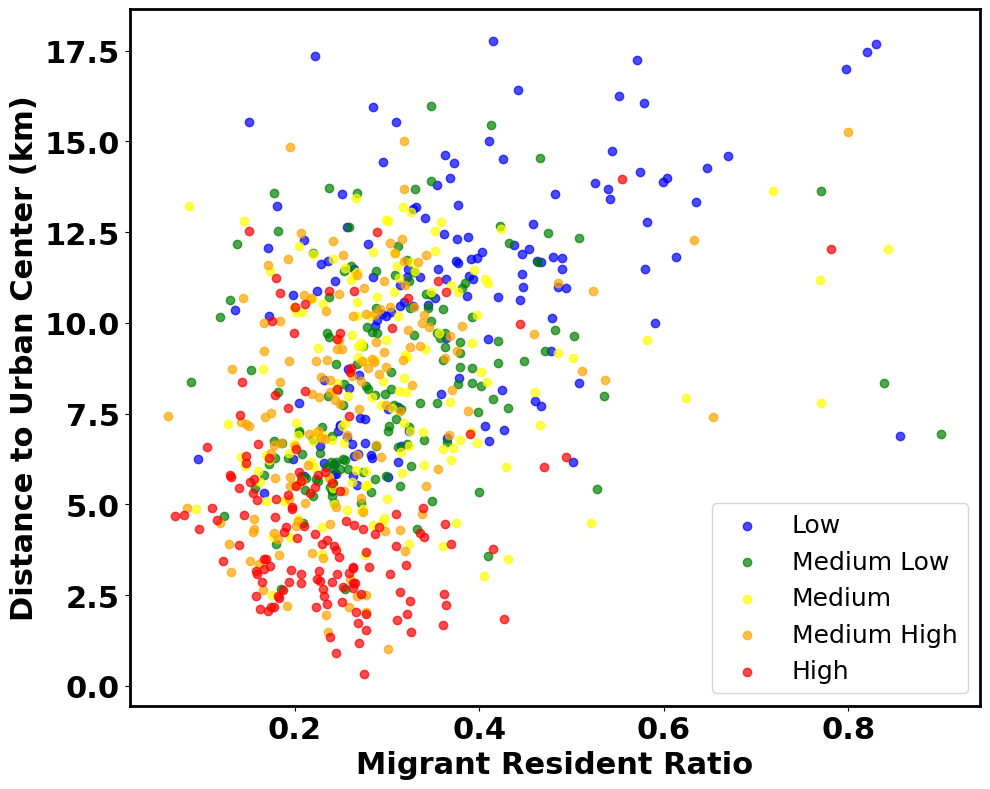

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import random

# 计算Gini系数的函数
def gini_coefficient(y):
    """计算Gini系数"""
    if len(y) == 0:
        return np.nan
    sorted_y = np.sort(y)
    n = len(y)
    coef = 2.0 * np.sum((np.arange(1, n + 1) - 1) * sorted_y) / (n * np.sum(sorted_y))
    return coef - (1.0 + 1.0 / n)

# 读取Excel文件
file_path = 'Community Data.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')  # 假设数据在Sheet1中

# 删除非户籍比重为0的行
df = df[df['Non-registered Resident Ratio'] != 0]

# 删除包含空值的行（如果有的话）
df.dropna(subset=['Non-registered Resident Ratio', 'Distance to Urban Center', 'Average Housing Price'], inplace=True)

# 提取数据列
non_local_ratio = df['Non-registered Resident Ratio']
facility_accessibility = df['Distance to Urban Center']  # 取对数
economic_status = df['Average Housing Price']

# 根据经济属性地位分成五类，并确定颜色映射
economic_status_bins = pd.qcut(economic_status, q=5, labels=['Low', 'Medium Low', 'Medium', 'Medium High', 'High'])
color_map = {
    'Low': 'blue',
    'Medium Low': 'green',
    'Medium': 'yellow',
    'Medium High': 'orange',
    'High': 'red'
}
# 'red', 'blue', 'green', 'orange', 'purple', 'brown'
# 创建图形和轴
plt.figure(figsize=(10, 8), linewidth=4)

# 记录每个经济属性地位类别的斜率K值
k_values = {}
gini_values = {}
mean_values = {}
# 绘制散点图和拟合回归线
for status_level, color in color_map.items():
    indices = economic_status_bins[economic_status_bins == status_level].index
    
    # 随机抽取一半的数据点索引
    num_samples = len(indices) //2
    selected_indices = random.sample(indices.tolist(), num_samples)
    
    x_data = non_local_ratio[selected_indices]
    y_data = facility_accessibility[selected_indices]
    
    # 绘制散点图
    plt.scatter(x_data, y_data, color=color, label=status_level, alpha=0.7)
    
    # 计算并绘制回归趋势线
    x_data_np = np.array(x_data).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_data_np, y_data)
    y_pred = model.predict(x_data_np)
    #plt.plot(x_data, y_pred, color=color, linestyle='--', linewidth=2)
    
    # 获取斜率K值
    slope = model.coef_[0]
    k_values[status_level] = slope
    
    # 计算均值
    mean_value = np.mean(y_data)
    mean_values[status_level] = mean_value

# 设置图例和标签
plt.xlabel('Migrant Resident Ratio',fontsize=22, weight='bold')
plt.ylabel('Distance to Urban Center (km)',fontsize=22, weight='bold')
#plt.title('社区非户籍比重与设施可达性距离关系', fontsize=14)

# 创建自定义图例，包括斜率K值和Gini系数
legend_labels = []
for status_level, color in color_map.items():
    legend_label = f'{status_level} (K={k_values[status_level]:.2f})'
    legend_labels.append(legend_label)

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=22, weight='bold')
plt.yticks(fontsize=22, weight='bold')

plt.legend(fontsize=18)
# 设置边框加粗
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

# 显示图形
# 关闭网格线
plt.grid(False)
plt.tight_layout()
plt.show()

Figure 1B: Community Facility Accessibility by Hukou and Socioeconomic Attribute Differentiation

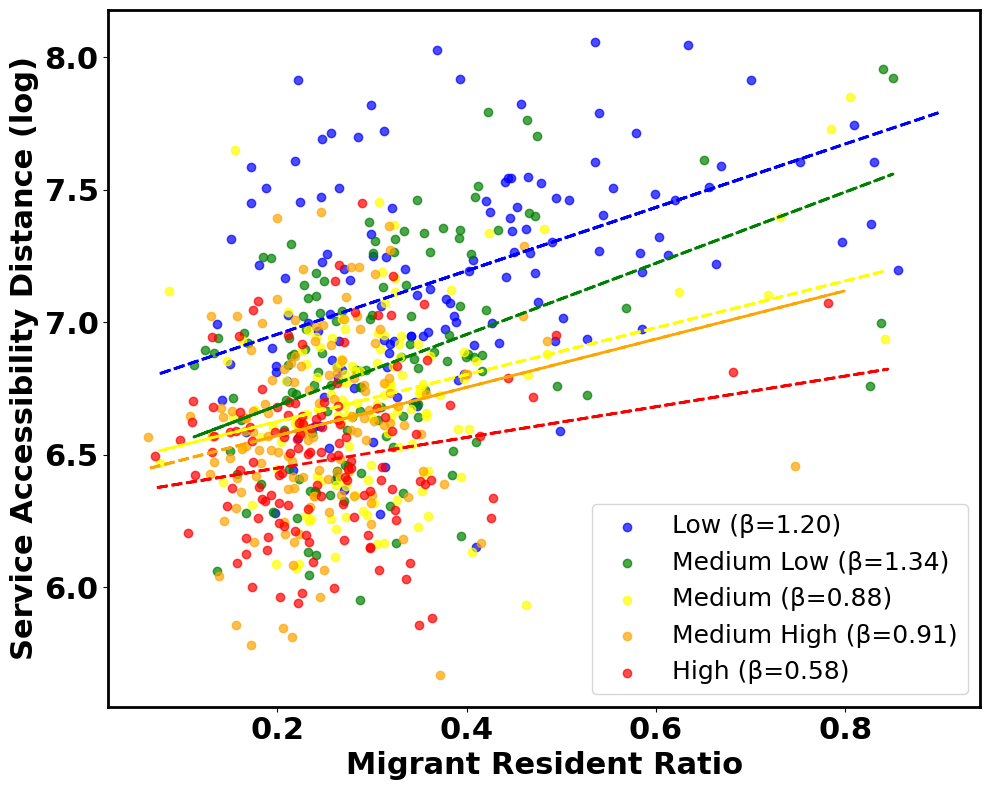

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import random

# 计算Gini系数的函数
def gini_coefficient(y):
    """计算Gini系数"""
    if len(y) == 0:
        return np.nan
    sorted_y = np.sort(y)
    n = len(y)
    coef = 2.0 * np.sum((np.arange(1, n + 1) - 1) * sorted_y) / (n * np.sum(sorted_y))
    return coef - (1.0 + 1.0 / n)

# 读取Excel文件
file_path = 'Community Data.xlsx'
df = pd.read_excel(file_path, sheet_name='Sheet1')  # 假设数据在Sheet1中

# 删除非户籍比重为0的行
df = df[df['Non-registered Resident Ratio'] != 0]

# 删除包含空值的行（如果有的话）
df.dropna(subset=['Non-registered Resident Ratio', 'Service Distance', 'Average Housing Price'], inplace=True)

# 提取数据列
non_local_ratio = df['Non-registered Resident Ratio']
facility_accessibility = np.log(df['Service Distance'])  # 取对数
economic_status = df['Average Housing Price']

# 根据经济属性地位分成五类，并确定颜色映射
economic_status_bins = pd.qcut(economic_status, q=5, labels=['Low', 'Medium Low', 'Medium', 'Medium High', 'High'])
color_map = {
    'Low': 'blue',
    'Medium Low': 'green',
    'Medium': 'yellow',
    'Medium High': 'orange',
    'High': 'red'
}
# 'red', 'blue', 'green', 'orange', 'purple', 'brown'
# 创建图形和轴
plt.figure(figsize=(10, 8), linewidth=4)

# 记录每个经济属性地位类别的斜率K值
k_values = {}
gini_values = {}
mean_values = {}
# 绘制散点图和拟合回归线
for status_level, color in color_map.items():
    indices = economic_status_bins[economic_status_bins == status_level].index
    x_data = non_local_ratio[indices]
    y_data = facility_accessibility[indices]
    
    # 随机抽取一半的数据点索引
    num_samples = len(indices) //2
    selected_indices = random.sample(indices.tolist(), num_samples)
    
    x_data_random = non_local_ratio[selected_indices]
    y_data_random = facility_accessibility[selected_indices]
    
    # 绘制散点图
    plt.scatter(x_data_random, y_data_random, color=color, label=status_level, alpha=0.7)
    
    # 计算并绘制回归趋势线
    x_data_np = np.array(x_data).reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_data_np, y_data)
    y_pred = model.predict(x_data_np)
    plt.plot(x_data, y_pred, color=color, linestyle='--', linewidth=2)
    
    # 获取斜率K值
    slope = model.coef_[0]
    k_values[status_level] = slope

    # 计算均值
    mean_value = np.mean(y_data)
    mean_values[status_level] = mean_value

# 设置图例和标签
plt.xlabel('Migrant Resident Ratio',fontsize=22, weight='bold')
plt.ylabel('Service Accessibility Distance (log)',fontsize=22, weight='bold')
#plt.title('社区非户籍比重与设施可达性距离关系', fontsize=14)

# 创建自定义图例，包括斜率K值和Gini系数
legend_labels = []
for status_level, color in color_map.items():
    legend_label = f'{status_level} (β={k_values[status_level]:.2f})'
    legend_labels.append(legend_label)

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=22, weight='bold')
plt.yticks(fontsize=22, weight='bold')
#plt.legend(title='SES',fontsize=12)
plt.legend(handles=plt.gca().get_legend_handles_labels()[0], labels=legend_labels,fontsize=18)
# 设置边框加粗
for spine in plt.gca().spines.values():
    spine.set_linewidth(2)

# 显示图形
# 关闭网格线
plt.grid(False)
plt.tight_layout()
plt.show()


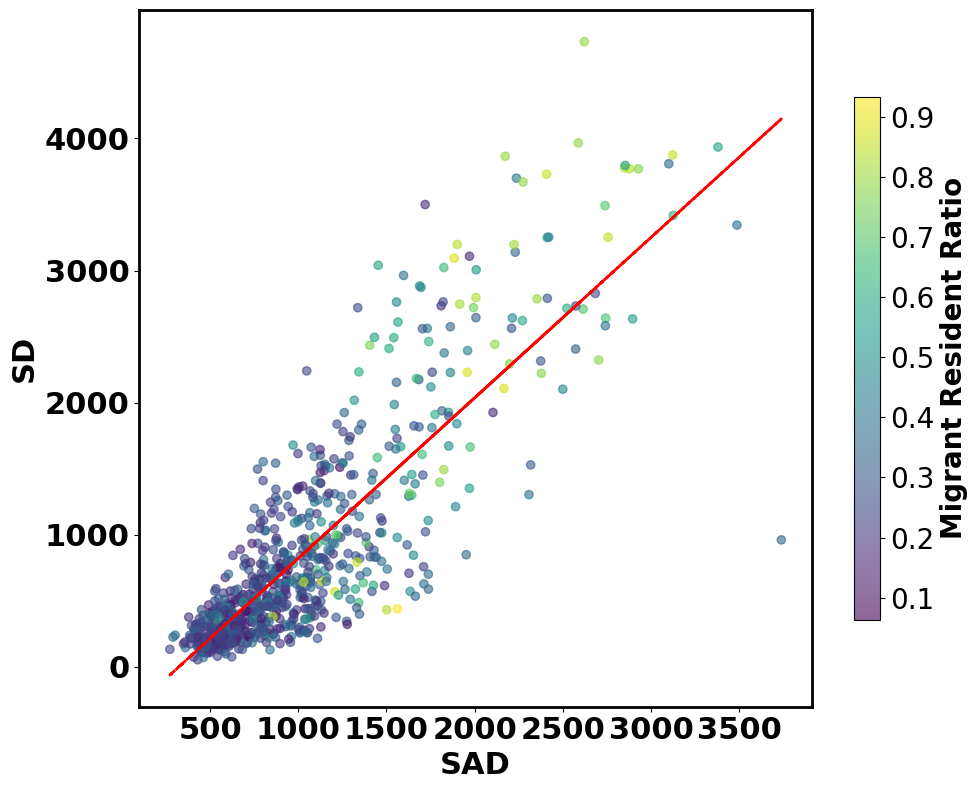

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# 读取Excel文件
file_path = 'Community Data.xlsx'  # 请替换为实际的Excel文件路径
df = pd.read_excel(file_path,"Sheet2")
# 删除包含空值的行（如果有的话）
df.dropna(subset=['Service Distance', 'Standard Deviation', 'Non-registered Resident Ratio'], inplace=True)

# 确保DataFrame包含必要的列
required_columns = ['Service Distance', 'Standard Deviation', 'Non-registered Resident Ratio']
if not all(col in df.columns for col in required_columns):
    raise ValueError(f"The Excel file must contain the following columns: {required_columns}")

# 提取数据
service_distance = df['Service Distance']
standard_deviation = df['Standard Deviation']
non_registered_ratio = df['Non-registered Resident Ratio']

# 随机选择一半的数据点
half_size = len(df) // 2
sampled_indices = np.random.choice(df.index, half_size, replace=False)
sampled_service_distance = service_distance[sampled_indices]
sampled_standard_deviation = standard_deviation[sampled_indices]
sampled_non_registered_ratio = non_registered_ratio[sampled_indices]

# 绘制散点图
plt.figure(figsize=(10, 8), linewidth=4)
scatter = plt.scatter(sampled_service_distance, sampled_standard_deviation, c=sampled_non_registered_ratio, cmap='viridis', alpha=0.6)
cbar = plt.colorbar(scatter, label='Non-registered Resident Ratio', shrink=0.75)

# 调整颜色条刻度和标签的字体大小
cbar.ax.tick_params(labelsize=20)  # 调整刻度字体大小
cbar.set_label('Migrant Resident Ratio', size=20, weight='bold')  # 调整颜色条标签字体大小

# 拟合趋势线
X = service_distance.values.reshape(-1, 1)
y = standard_deviation.values
reg = LinearRegression().fit(X, y)
trendline = reg.predict(X)

# 绘制拟合趋势线
plt.plot(service_distance, trendline, color='red', linestyle='--', linewidth=2, label='Trend Line')

# 添加标题和标签
# plt.title('Service Distance vs Standard Deviation')
plt.xlabel('SAD',fontsize=22, weight='bold')
plt.ylabel('SD',fontsize=22, weight='bold')

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=22, weight='bold')
plt.yticks(fontsize=22, weight='bold')

# 设置边框加粗且为黑色
ax = plt.gca()  # 获取当前的轴
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')  # 设置边框颜色为黑色

# 显示图表
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats

# 获取斜率和截距
slope = reg.coef_[0]
intercept = reg.intercept_

# 计算R方值
r_squared = reg.score(X, y)

# 计算显著性和p值
# 这里使用stats.linregress计算t统计量和p值
t_stat, p_value, _, _, _ = stats.linregress(sampled_service_distance, sampled_standard_deviation)

# 打印结果
print(f"斜率 (slope): {slope:.4f}")
print(f"截距 (intercept): {intercept:.4f}")
print(f"R方值 (R^2): {r_squared:.4f}")
print(f"显著性 (p值): {p_value:.4f}")

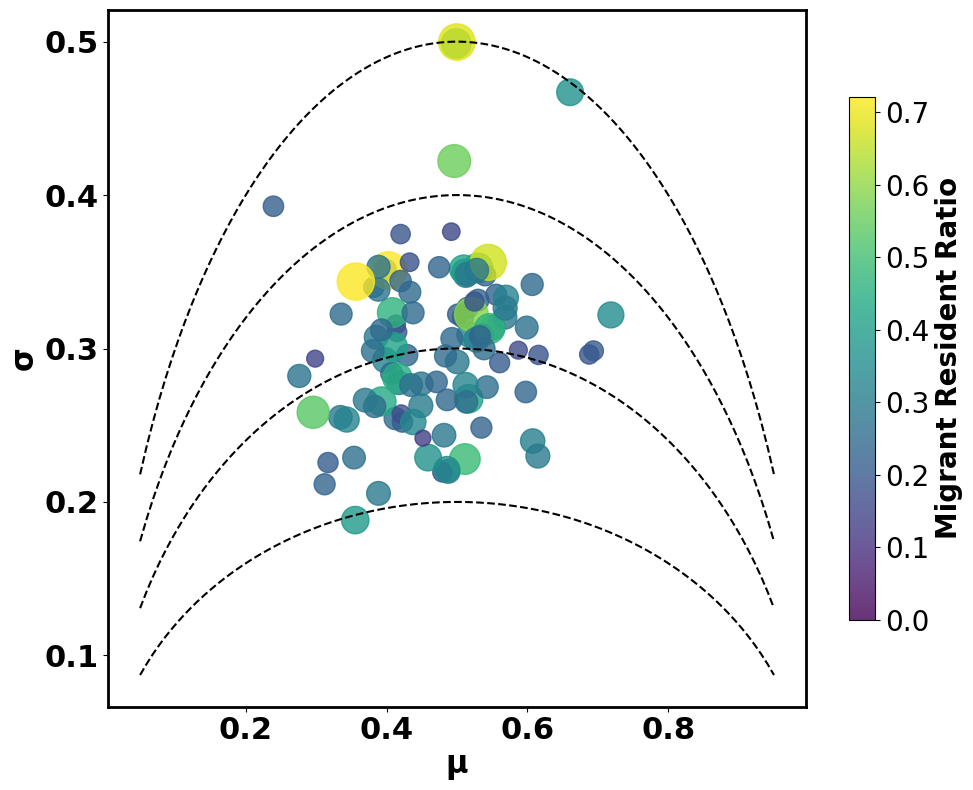

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 读取Excel文件
df = pd.read_excel('Subdistrict Data.xlsx')

# 提取数据
mu = df['μ']
sigma = df['σ']
non_registered_ratio = df['Non-registered Resident Ratio']
imbalance_index = df['I']

# 这里使用非户籍比重乘以100作为散点大小，乘以适当的系数以调整大小
scatter_size = non_registered_ratio*1000

# 绘制散点图
plt.figure(figsize=(10, 8), linewidth=4)
scatter = plt.scatter(mu, sigma, c=non_registered_ratio, s=scatter_size, cmap='viridis', alpha=0.8)
cbar = plt.colorbar(scatter, label='Non-registered Resident Ratio', shrink=0.75)
# 调整颜色条刻度和标签的字体大小
cbar.ax.tick_params(labelsize=20)  # 调整刻度字体大小
cbar.set_label('Migrant Resident Ratio', size=20, weight='bold')  # 调整颜色条标签字体大小

plt.xlabel('μ',fontsize=22, weight='bold')
plt.ylabel('σ',fontsize=22, weight='bold')
#plt.title('μ vs. σ 散点图')

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=22, weight='bold')
plt.yticks(fontsize=22, weight='bold')

# 绘制拟合虚线
I_values = [1.0, 0.8, 0.6, 0.4]
colors = ['black', 'black', 'black', 'black', 'black', 'black', 'black']
for I, color in zip(I_values, colors):
    mu_fit = np.linspace(0.05, 0.95, 100)
    sigma_fit = I * np.sqrt(mu_fit * (1 - mu_fit))
    plt.plot(mu_fit, sigma_fit, linestyle='--', color=color, label=f'Inequality={I}')

# 调整图例字体大小
#plt.legend(fontsize=14)
# 设置边框加粗且为黑色
ax = plt.gca()  # 获取当前的轴
for spine in ax.spines.values():
    spine.set_linewidth(2)
    spine.set_color('black')  # 设置边框颜色为黑色

# 显示图表
plt.grid(False)
plt.tight_layout()
plt.show()

In [74]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 假设你的数据框为 df，包含所有的解释变量
# 例如：
df = data[attributes]

# 添加常数项（拦截）
x = sm.add_constant(df)

# 计算 VIF 值
vif = pd.DataFrame()
vif["Variable"] = x.columns
vif["VIF"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]

print(vif)


                        Variable        VIF
0                          const  77.033764
1  Non-registered Resident Ratio   1.305703
2          Average Housing Price   1.916134
3        Bachelor's Degree Ratio   1.350804
4       Distance to Urban Center   1.836657
5               Build Area Ratio   2.064160
6              Road Length Ratio   1.235946
7               Green Area Ratio   1.507713
8                    POP density   1.185206


Quantitative Regression Model

In [73]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 从 Excel 文件读取数据
data = pd.read_excel('Community Data.xlsx', 'Sheet1')
data.dropna(inplace=True)
# 假设 Excel 文件中包含六类属性以及非户籍人口比重 'NonHukouPopulationRatio'
attributes = ["Non-registered Resident Ratio","Average Housing Price","Bachelor's Degree Ratio","Distance to Urban Center","Build Area Ratio","Road Length Ratio","Green Area Ratio","POP density"]
target = 'Service Distance'

# 构建回归模型
X = data[attributes]
#X["Average Housing Price"]=np.log(X["Average Housing Price"])
#X["POP density"]=np.log(X["POP density"])
y = np.log(data[target])

# 添加常数项（截距）
X = sm.add_constant(X)

# 进行回归分析
model = sm.OLS(y, X).fit()

# 输出回归结果
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       Service Distance   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     178.2
Date:                Thu, 27 Jun 2024   Prob (F-statistic):          7.06e-204
Time:                        22:08:13   Log-Likelihood:                -299.99
No. Observations:                1330   AIC:                             618.0
Df Residuals:                    1321   BIC:                             664.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

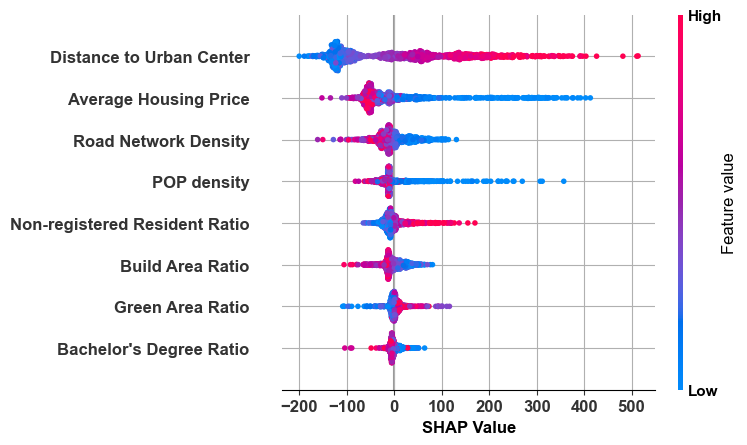

In [2]:
import shap
import numpy as np
import pandas as pd
import xgboost
import matplotlib.pyplot as plt
import lightgbm as lgb

# 加载数据
# X, y = shap.datasets.california()
df = pd.read_excel('Community Data.xlsx','Sheet1')

# 删除包含空值的行（如果有的话）
df.dropna(inplace=True)
df=df[df['Non-registered Resident Ratio'] != 0]
X=df[["Non-registered Resident Ratio","Average Housing Price","Bachelor's Degree Ratio","Distance to Urban Center","Build Area Ratio","Road Network Density","Green Area Ratio","POP density"]]
y=df[["Service Distance"]]

# 训练XGBoost模型
model =  xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# 创建解释器
explainer = shap.TreeExplainer(model)

# 计算Shapley值
shap_values = explainer.shap_values(X)
# 设置字体为新罗马字体和字体大小

# 设置字体为Arial字体和字体大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14  # 设置全局字体大小为14
plt.rcParams['font.weight'] = 'bold'  # 设置全局字体加粗
# 创建新的图像并设置大小
plt.figure(figsize=(10, 6))  # 可以根据需要调整图像大小

# 创建新的图像并设置大小
# 绘制 Shapley 值的总结图，并设置字体大小
shap.summary_plot(shap_values, X, show=False)
#plt.title('SHAP Summary Plot', fontsize=20)
plt.xlabel('SHAP Value', fontsize=12, fontweight='bold')
#plt.ylabel('Feature', fontsize=14)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
# 添加网格线
plt.grid(True)
plt.show()

<Figure size 1000x600 with 0 Axes>

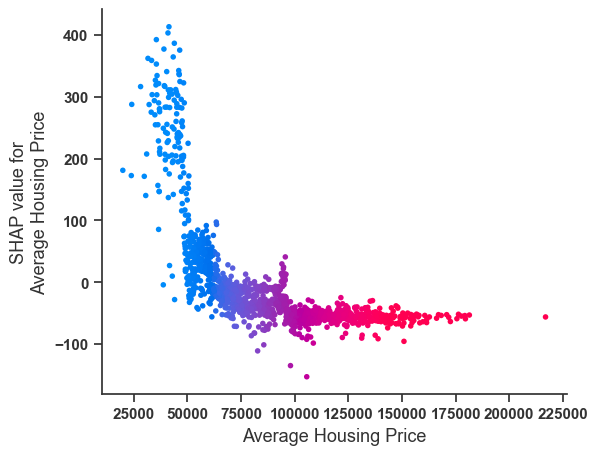

In [74]:
import shap
import matplotlib.pyplot as plt
import pandas as pd
import xgboost
from scipy.signal import find_peaks
# 加载数据
# 计算Shapley值
shap_values = explainer.shap_values(X)

# 创建新的图像并设置大小
plt.figure(figsize=(10, 6))  # 可以根据需要调整图像大小

# 绘制依赖图，指定 ax 参数
# 可视化 Average Housing Price 特征对模型预测的影响
shap.dependence_plot("Average Housing Price", shap_values, X, 
                     display_features=X,
                     interaction_index='Average Housing Price')


# 设置字体为 Arial 和字体大小
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 14  # 设置全局字体大小
plt.rcParams['font.weight'] = 'bold'  # 设置全局字体加粗
plt.show()
           

Histogram

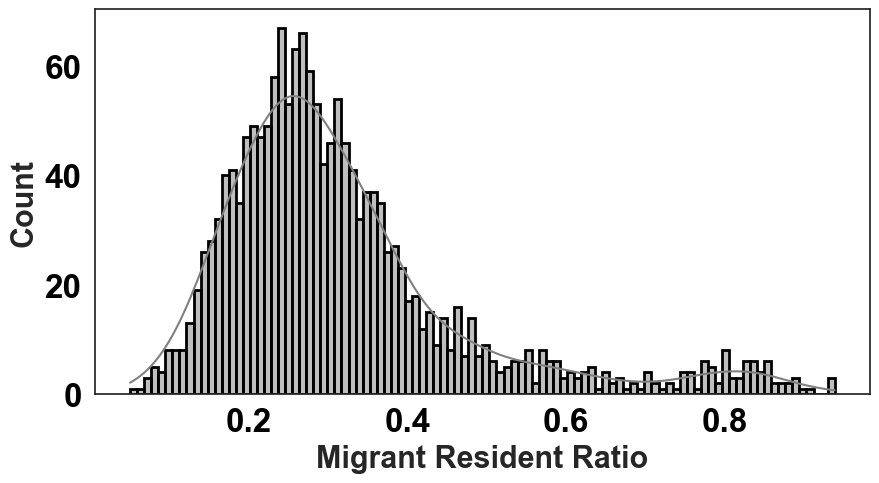

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
# 使用 seaborn 设置图形样式
import seaborn as sns
sns.set(style="white")

# 假设数据已经处理成了特征矩阵 X 和目标变量 y
df = pd.read_excel('Community Data.xlsx','Sheet1')
# 创建画布和子图
fig, ax = plt.subplots(figsize=(10, 5), edgecolor='black')

# 过滤掉 'Non-registered Resident Ratio' 值为0的行
df_filtered = df[df['Non-registered Resident Ratio'] != 0]
# 绘制频率分布图
sns.histplot(df_filtered["Non-registered Resident Ratio"], bins=100, kde=True, color='grey', linewidth=2, edgecolor='black')  # 设置 bins 参数来控制直方图的箱数，kde=True 表示绘制核密度估计曲线
ax.set_xlabel('Migrant Resident Ratio',size=22, fontweight='bold')  # 设置字体加粗
ax.set_ylabel('Count', size=22,fontweight='bold')  # 设置字体加粗

# 设置 x 轴和 y 轴标签的字体大小和颜色
ax.tick_params(axis='x', labelsize=24, labelcolor='black')
ax.tick_params(axis='y', labelsize=24, labelcolor='black')

# 设置 x 轴和 y 轴刻度的字体加粗
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.show()

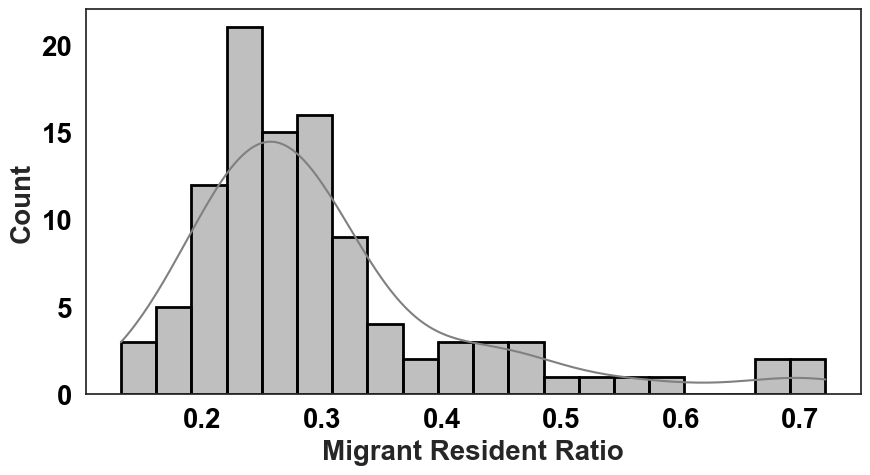

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
# 使用 seaborn 设置图形样式
import seaborn as sns
sns.set(style="white")

# 假设数据已经处理成了特征矩阵 X 和目标变量 y
df = pd.read_excel('Subdistrict Data.xlsx','Sheet1')
# 创建画布和子图
fig, ax = plt.subplots(figsize=(10, 5), edgecolor='black')

# 过滤掉 'Non-registered Resident Ratio' 值为0的行
df_filtered = df[df['Non-registered Resident Ratio'] != 0]
# 绘制频率分布图
sns.histplot(df_filtered["Non-registered Resident Ratio"], bins=20, kde=True, color='grey', linewidth=2, edgecolor='black')  # 设置 bins 参数来控制直方图的箱数，kde=True 表示绘制核密度估计曲线
ax.set_xlabel('Migrant Resident Ratio',size=20, fontweight='bold')  # 设置字体加粗
ax.set_ylabel('Count', size=20,fontweight='bold')  # 设置字体加粗

# 设置 x 轴和 y 轴标签的字体大小和颜色
ax.tick_params(axis='x', labelsize=20, labelcolor='black')
ax.tick_params(axis='y', labelsize=20, labelcolor='black')

# 设置 x 轴和 y 轴刻度的字体加粗
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

plt.show()

Quadrant Analysis

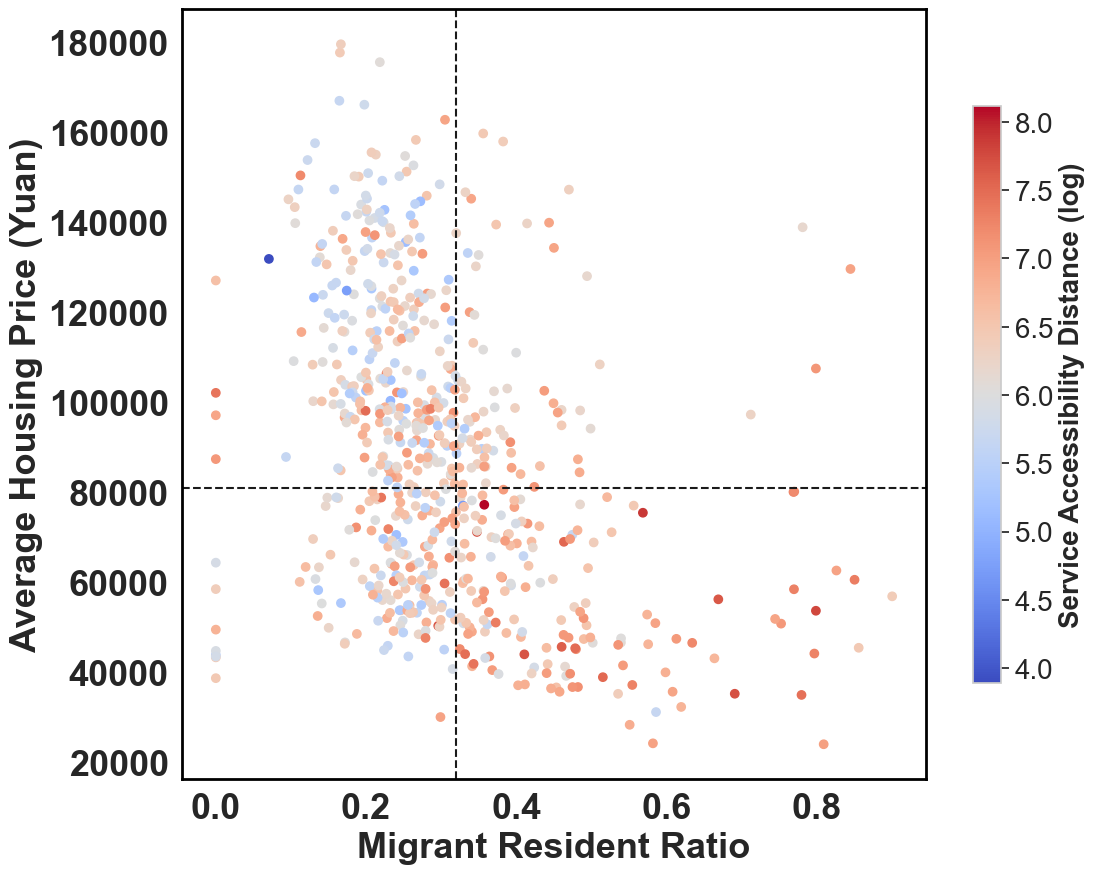

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 加载Excel文件
file_path = 'Community Data.xlsx' # 请替换为您的Excel文件路径
df = pd.read_excel(file_path, 'Sheet1')
df.dropna(inplace=True)
# 随机选取一半的数据
df_sample = df.sample(frac=0.5, random_state=1)

# 提取所需的列
x = df_sample['Non-registered Resident Ratio']
y = df_sample['Average Housing Price']
color = np.log(df_sample['Primary Education'])
# 设置十字虚线的坐标
cross_x = 0.32
cross_y = 80885.9

# 绘制散点图
fig, ax = plt.subplots(figsize=(12, 10))
# 添加十字虚线
ax.axhline(y=cross_y, color='k', linestyle='--')
ax.axvline(x=cross_x, color='k', linestyle='--')

scatter = ax.scatter(x, y, c=color, cmap='coolwarm', alpha=1)
cbar = plt.colorbar(scatter, ax=ax, label='Service Accessibility Distance (log)', shrink=0.75)
#cbar.set_label('Service Accessibility Distance (log)', rotation=270, labelpad=15)
# 调整颜色条刻度和标签的字体大小
cbar.ax.tick_params(labelsize=20)  # 调整刻度字体大小
cbar.set_label('Service Accessibility Distance (log)', size=20, weight='bold')  # 调整颜色条标签字体大小

ax.set_xlabel('Migrant Resident Ratio',fontsize=26, weight='bold')
ax.set_ylabel('Average Housing Price (Yuan)',fontsize=26, weight='bold')
# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=26, weight='bold')
plt.yticks(fontsize=26, weight='bold')
#plt.title('Scatter Plot of Housing Price vs. Non-registered Resident Ratio')
ax.grid(True)

# 设置图形背景为白色
ax.set_facecolor('white')
plt.grid(False)  # 去除底板网格

# 加粗边框
# 设置边框颜色为黑色并加粗
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)
plt.show()


C:\Users\Dell\AppData\Local\Temp\ipykernel_9732\205332521.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_total_population = df_sorted.groupby('Distance Category')['Resident Population'].sum()
C:\Users\Dell\AppData\Local\Temp\ipykernel_9732\205332521.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_migrant_population = df_sorted.groupby('Distance Category')['Permanent Migrant Population'].sum()


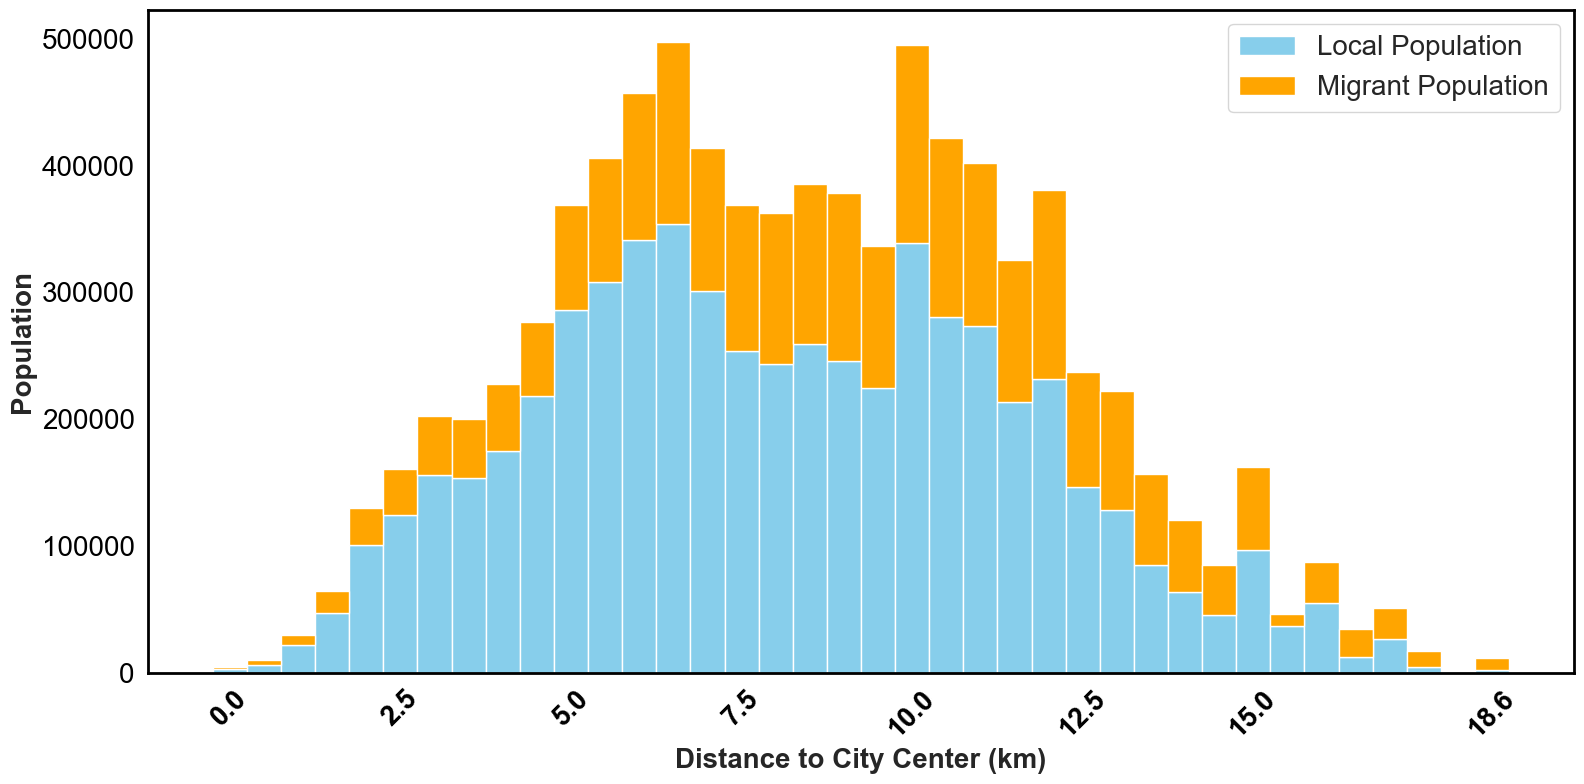

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置Seaborn风格
sns.set(style='whitegrid')

# 假设Excel文件名为'beijing_communities.xlsx'
file_path = 'Community Data.xlsx'

# 读取Excel文件中的数据
df = pd.read_excel(file_path, 'Sheet1')

# 确保列名正确
df = df[['Distance to Urban Center', 'Resident Population', 'Permanent Migrant Population']]

# 按照距离市中心的距离进行排序
df_sorted = df.sort_values(by='Distance to Urban Center')

# 获取最大距离
max_distance = df_sorted['Distance to Urban Center'].max()

# 分层: 使用numpy的arange函数以0.5公里为步长
bins = np.arange(0, max_distance + 0.5, 0.5)
df_sorted['Distance Category'] = pd.cut(df_sorted['Distance to Urban Center'], bins=bins)

# 分组统计每个层级的总常住人口和外来常住人口总数
grouped_total_population = df_sorted.groupby('Distance Category')['Resident Population'].sum()
grouped_migrant_population = df_sorted.groupby('Distance Category')['Permanent Migrant Population'].sum()

# 计算本地户籍人口
grouped_local_population = grouped_total_population - grouped_migrant_population

# 设置图表尺寸
fig, ax = plt.subplots(figsize=(16, 8))

# 绘制叠加柱状图
bar_width = 1
bar_positions = np.arange(len(grouped_total_population))

bars_local = ax.bar(bar_positions, grouped_local_population, bar_width, label='Local Population', color='skyblue')
bars_migrant = ax.bar(bar_positions, grouped_migrant_population, bar_width, bottom=grouped_local_population, label='Migrant Population', color='orange')

# 设置标题和标签
#ax.set_title('Population Distribution by Distance to City Center', fontsize=16, weight='bold')
ax.set_xlabel('Distance to City Center (km)', fontsize=20, weight='bold')
ax.set_ylabel('Population', fontsize=20, weight='bold')

# 设置x轴刻度，只显示0, 5, 10, 15和最大值
xticks_positions = [0, int(2.5 / 0.5), int(5 / 0.5), int(7.5 / 0.5), int(10 / 0.5), int(12.5 / 0.5), int(15 / 0.5), len(grouped_total_population) - 1]
xticks_labels = [0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, f'{max_distance:.1f}']

# 设置刻度线方向为外部，并设置长度和宽度
ax.tick_params(axis='both', direction='out', length=6, width=2, colors='black', labelsize=20) # 设置y轴刻度字体大小
ax.set_xticks(xticks_positions)
ax.set_xticklabels(xticks_labels, rotation=45, fontsize=20, weight='bold')

# 添加图例
ax.legend(fontsize=20)

# 去掉顶部和右侧边框，同时不显示网格线
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(False)
# 调整边框
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()

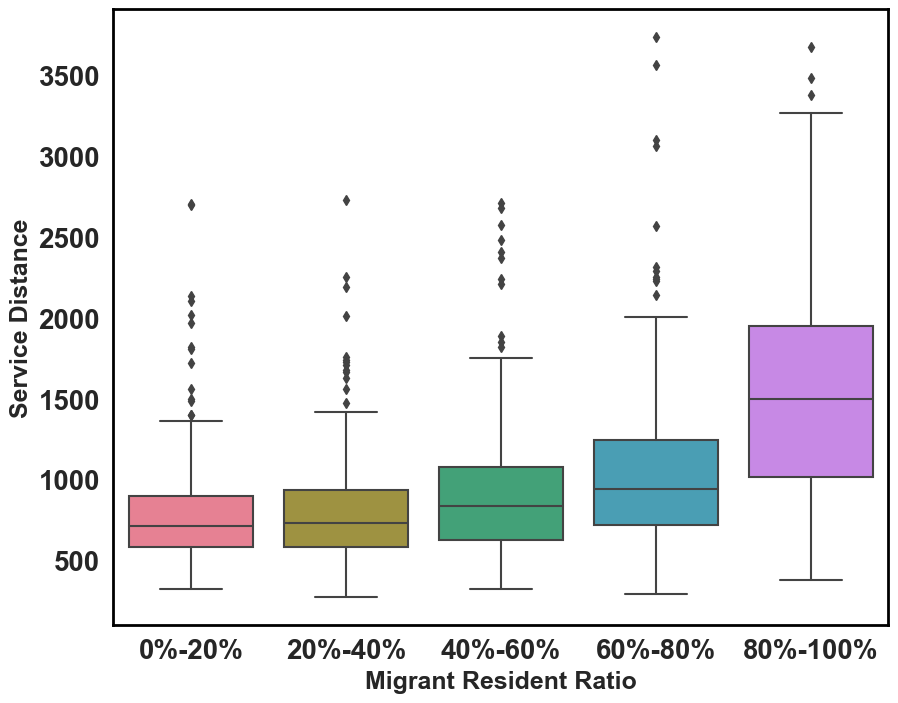

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 seaborn 设置图形样式
sns.set(style="whitegrid")

# 假设数据已经处理成了特征矩阵 X 和目标变量 y
df = pd.read_excel('Community Data.xlsx','Sheet1')

# 按照分位数划分数据为五个类别
quantiles = df['Non-registered Resident Ratio'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

# 设置画布
plt.figure(figsize=(10, 8))

# 设置调色板，根据分组数设定不同的颜色
colors = sns.color_palette("husl", 5)

# 绘制箱线图，并调整箱体宽度
sns.boxplot(x=pd.cut(df['Non-registered Resident Ratio'], bins=quantiles, labels=['0%-20%', '20%-40%', '40%-60%', '60%-80%', '80%-100%']), y='Service Distance', data=df, palette=colors, linewidth=1.5)

# 设置图标题和轴标签
# plt.title('Boxplot of Public Spaces Accessibility by Non-registered Resident Ratio', fontsize=12, weight='bold')
plt.xlabel('Migrant Resident Ratio', fontsize=18, weight='bold')
plt.ylabel('Service Distance', fontsize=18, weight='bold')

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight='bold')

plt.xticks(rotation=0)  # 旋转 x 轴标签，以免重叠

# 关闭网格线
plt.grid(False)

# 调整边框
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_20276\2070212798.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
C:\Users\Dell\AppData\Local\Temp\ipykernel_20276\2070212798.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=pd.cut(df['Average Housing Price'], bins=quantiles, labels=['Low', 'Medium Low', 'Medium', 'Medium High', 'High']), y='Public Security Agencies', data=df, palette=colors, linewidth=1.5)


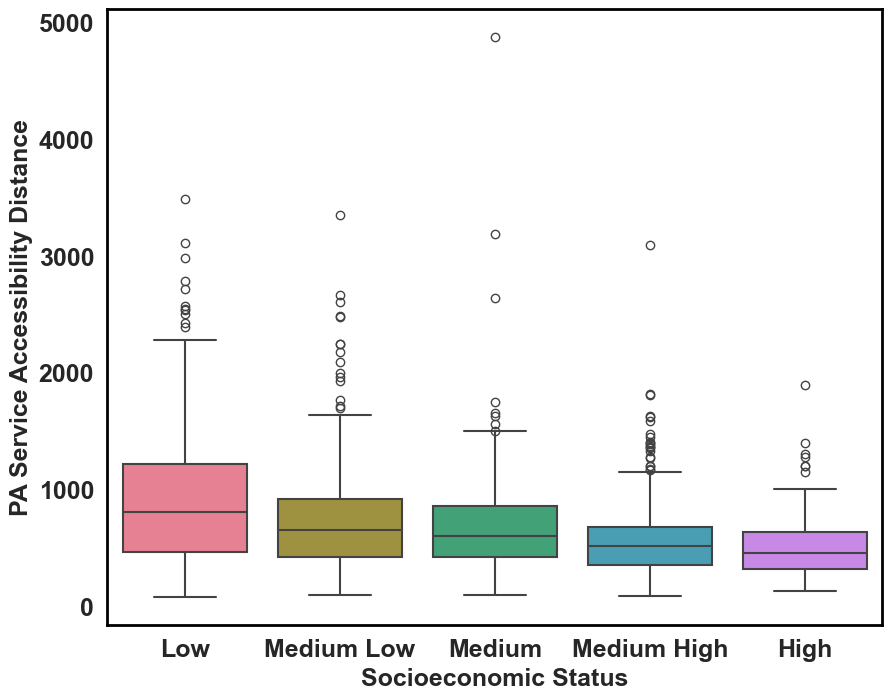

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 seaborn 设置图形样式
sns.set(style="whitegrid")

# 假设数据已经处理成了特征矩阵 X 和目标变量 y
df = pd.read_excel('Community Data.xlsx','Sheet1')

# 按照分位数划分数据为五个类别
quantiles = df['Average Housing Price'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

# 设置画布
plt.figure(figsize=(10, 8))

# 设置调色板，根据分组数设定不同的颜色
colors = sns.color_palette("husl", 5)

# 绘制箱线图，并调整箱体宽度
sns.boxplot(x=pd.cut(df['Average Housing Price'], bins=quantiles, labels=['Low', 'Medium Low', 'Medium', 'Medium High', 'High']), y='Public Security Agencies', data=df, palette=colors, linewidth=1.5)

# 设置图标题和轴标签
# plt.title('Boxplot of Public Spaces Accessibility by Non-registered Resident Ratio', fontsize=12, weight='bold')
plt.xlabel('Socioeconomic Status', fontsize=18, weight='bold')
plt.ylabel('PA Service Accessibility Distance', fontsize=18, weight='bold')

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=18, weight='bold')
plt.yticks(fontsize=18, weight='bold')

plt.xticks(rotation=0)  # 旋转 x 轴标签，以免重叠

# 关闭网格线
plt.grid(False)

# 调整边框
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.show()

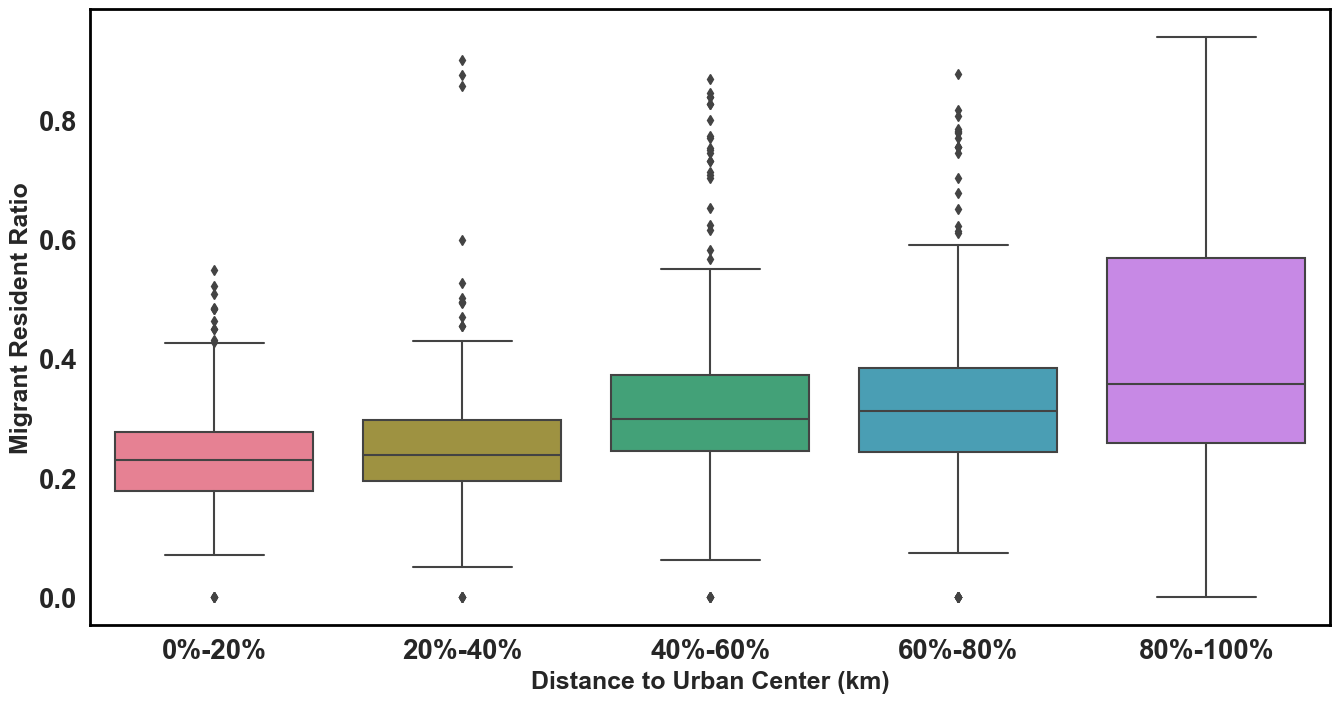

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 seaborn 设置图形样式
sns.set(style="whitegrid")

# 假设数据已经处理成了特征矩阵 X 和目标变量 y
df = pd.read_excel('Community Data.xlsx','Sheet1')

# 按照分位数划分数据为五个类别
quantiles = df['Distance to Urban Center'].quantile([0, 0.2, 0.4, 0.6, 0.8, 1])

# 设置画布
plt.figure(figsize=(16, 8))

# 设置调色板，根据分组数设定不同的颜色
colors = sns.color_palette("husl", 5)

# 绘制箱线图，并调整箱体宽度
sns.boxplot(x=pd.cut(df['Distance to Urban Center'], bins=quantiles, labels=['0%-20%', '20%-40%', '40%-60%', '60%-80%', '80%-100%']), y='Non-registered Resident Ratio', data=df, palette=colors, linewidth=1.5)

# 设置图标题和轴标签
# plt.title('Boxplot of Public Spaces Accessibility by Non-registered Resident Ratio', fontsize=12, weight='bold')
plt.xlabel('Distance to Urban Center (km)', fontsize=18, weight='bold')
plt.ylabel('Migrant Resident Ratio', fontsize=18, weight='bold')

# 调整坐标轴的数字字体大小和加粗
plt.xticks(fontsize=20, weight='bold')
plt.yticks(fontsize=20, weight='bold')

plt.xticks(rotation=0)  # 旋转 x 轴标签，以免重叠

# 关闭网格线
plt.grid(False)

# 调整边框
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

plt.show()